In [40]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [41]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [42]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [43]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [44]:
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

In [45]:
param_grid = {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [-1, 10, 20],
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [1, 5, 10]
}

In [46]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [47]:
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scoring,
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

In [48]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 4898, number of negative: 4898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31323
[LightGBM] [Info] Number of data points in the train set: 9796, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'm...
                                        'subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   random_state=42, refit='f1_macro', return_train_score=True,
                   scoring={'accuracy': 'accuracy',
                            'f1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                            'precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                            'recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
                   verbose=2)

In [59]:
best_params = random_search.best_params_
print("Melhores hiperparâmetros encontrados:", best_params)

Melhores hiperparâmetros encontrados: {'subsample': np.float64(0.5), 'num_leaves': np.int64(80), 'n_estimators': np.int64(450), 'max_depth': np.int64(16), 'learning_rate': np.float64(0.1), 'colsample_bytree': np.float64(1.0)}


In [60]:
def get_results(search):
    results = pd.DataFrame(search.cv_results_)
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_num_leaves', 'param_max_depth', 'param_learning_rate',
            'param_n_estimators', 'param_subsample', 'param_colsample_bytree', 'mean_test_accuracy',
            'rank_test_accuracy', 'mean_test_precision_macro', 'rank_test_precision_macro',
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]
    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [61]:
pd.set_option('display.max_columns', None)
results = get_results(random_search)

In [62]:
results.head(100)

,mean_fit_time,mean_score_time,param_num_leaves,param_max_depth,param_learning_rate,param_n_estimators,param_subsample,param_colsample_bytree,mean_test_accuracy,rank_test_accuracy,mean_test_precision_macro,rank_test_precision_macro,mean_test_recall_macro,rank_test_recall_macro,mean_test_f1_macro,rank_test_f1_macro
99,37.932066,0.085885,80,16,0.100000,450,0.500,1.000,0.927931,1,0.929766,2,0.927933,1,0.927855,1
51,30.987862,0.036991,80,16,0.100000,150,0.500,0.500,0.927828,2,0.929908,1,0.927831,2,0.927742,2
86,33.127969,0.049139,130,16,0.464159,250,0.875,1.000,0.927523,3,0.929009,4,0.927524,3,0.927460,3
45,26.360019,0.036826,80,11,0.046416,150,0.625,1.000,0.927216,4,0.928927,6,0.927218,4,0.927144,4
76,25.345012,0.045821,120,10,0.464159,250,0.875,0.875,0.927114,5,0.928562,12,0.927116,5,0.927054,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,3.441006,0.031239,40,5,0.010000,50,0.500,0.875,0.873930,96,0.874090,96,0.873930,96,0.873917,96
6,9.273654,0.033113,70,4,0.002154,250,0.875,0.625,0.873317,97,0.873769,97,0.873316,97,0.873278,97
71,5.119368,0.035210,30,19,0.002154,50,0.875,1.000,0.872195,98,0.873070,98,0.872195,98,0.872118,98
26,3.467722,0.034293,40,3,0.001000,150,0.625,0.750,0.845857,99,0.847431,99,0.845859,99,0.845686,99


In [63]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, search):
    results_df = pd.DataFrame(search.cv_results_)
    
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]
    
    if filter_top_n and "rank_test_f1_macro" in results_df.columns:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")
    
    param_cols = [col for col in results_df.columns if col.startswith('param_')]
    
    if not param_cols:
        print("Nenhuma coluna de parâmetro encontrada!")
        return
    
    plot_df = results_df.melt(
        id_vars=param_cols,
        value_vars=metrics,
        var_name="metric",
        value_name="score"
    )
    
    plt.figure(figsize=(12, 8))
    for (combo, group) in plot_df.groupby(param_cols, dropna=False):
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")
    
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics - LightGBM (Balanced)")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

C:\Users\rafap\AppData\Local\Temp\ipykernel_18156\2323452608.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


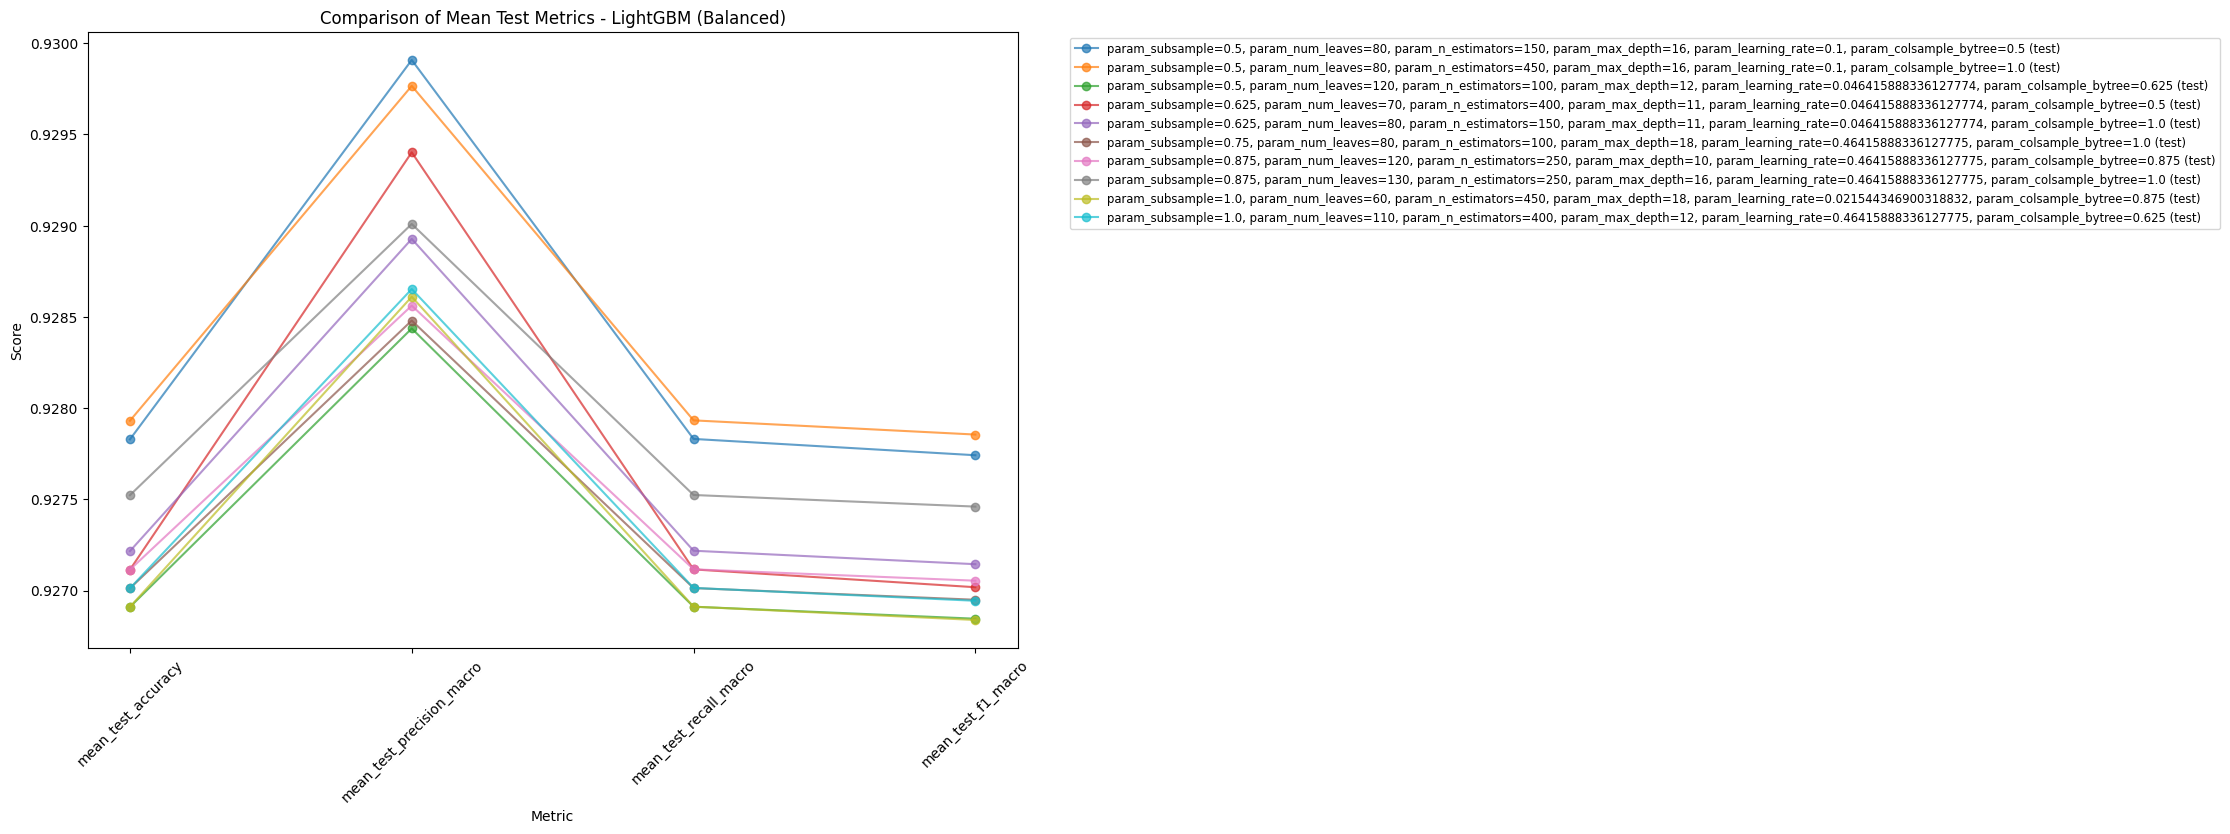

In [54]:
view_test_metrics(False, 10, random_search)

In [55]:
y_pred_cv = cross_val_predict(random_search.best_estimator_, X_train, y_train, cv=cv, n_jobs=-1)

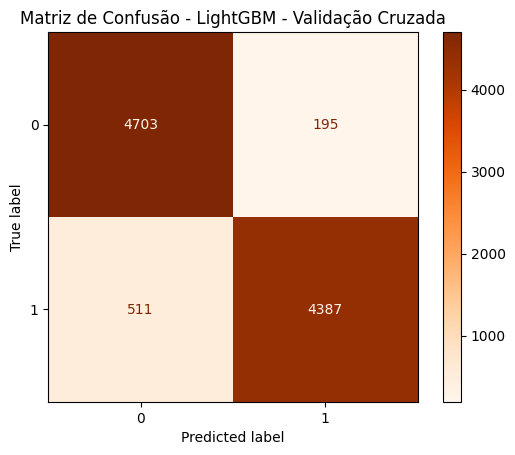

In [56]:
cm_cv = confusion_matrix(y_train, y_pred_cv)
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=random_search.best_estimator_.classes_)
disp_cv.plot(cmap=plt.cm.Oranges)
plt.title("Matriz de Confusão - LightGBM - Validação Cruzada")
plt.show()

In [57]:
y_pred_test = random_search.best_estimator_.predict(X_test)
print("Relatório de Classificação no Teste:\n", classification_report(y_test, y_pred_test))

Relatório de Classificação no Teste:
               precision    recall  f1-score   support

           0       0.90      0.96      0.92      2100
           1       0.66      0.43      0.52       414

    accuracy                           0.87      2514
   macro avg       0.78      0.69      0.72      2514
weighted avg       0.86      0.87      0.86      2514



c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [58]:
joblib.dump(random_search.best_estimator_, 'models/lightgbm.pkl')

['models/lightgbm.pkl']